# CH4 Time Series Preprocessing and EDA
**Purpose**: Prepare methane (CH4) data for forecasting using `GasPreprocessor`  

## Workflow  
1. Load cleaned GHG data  
2. Initialize preprocessor  
3. Fit/transform GHG data series  
4. Save processed data  

**Input**: `data/processed/df_model.csv`  
**Output**: `data/processed/ch4_preprocessed_df.csv`  

[View GasPreprocessor docs](../src/preprocessing.py)  

**Note**: The identical preprocessing will be reapplied to the training set in `4_ch4_modeling.ipynb`  
to avoid data leakage. This full-dataset version is for exploratory purposes only.

In [17]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from src.preprocessing import GasPreprocessor
print('GasPreprocessor imported sucessfully!')

GasPreprocessor imported sucessfully!


# Load and inspect data

In [4]:
# load cleaned data (with negative values --> NaN)
df = pd.read_csv(
    '../data/processed/df_model.csv',
    index_col=0,
    parse_dates=True,
    dtype={'value': float, 'value_unc': float, 'qcflag': str}
)

print(f'loaded {len(df)} records')
display(df.head())

loaded 1746 records


,value,value_unc,qcflag
1991-01-04,1719.845,2.71,...
1991-01-11,1736.940,2.71,...
1991-01-18,1728.335,2.71,...
1991-01-25,1716.080,2.71,...
1991-02-01,1727.430,2.71,...


In [5]:
# Check input data before calling fit_transform
print(f"df date range: {df.index.min()} to {df.index.max()}")
print(f"Input data shape: {df[['value', 'value_unc', 'qcflag']].shape}")
print(f"NaN values in value: {df['value'].isna().sum()}")
print(f"NaN values in value_unc: {df['value_unc'].isna().sum()}")
print(f"NaN values in qcflag: {df['qcflag'].isna().sum()}")
print(f"Negative values in value: {(df['value'] < 0).sum()}")

df date range: 1991-01-04 00:00:00 to 2024-12-31 00:00:00
Input data shape: (1746, 3)
NaN values in value: 0
NaN values in value_unc: 0
NaN values in qcflag: 0
Negative values in value: 0


# Initialize the preprocessor class

In [6]:
# rename the 'value' column to 'CH4' for consistency with the GasPreprocessor input expectations
df = df.rename(columns={'value': 'CH4'})

preprocessor = GasPreprocessor(
    gas_name='CH4',   
    iqr_factor=3.0
)

# Cleaned CH4 data preprocessing and EDA


[INFO] Fitting preprocessing for CH4
Raw data: 1746 points, 0 NaNs
Trimmed data: 1746 points, 0 NaNs
Data range after trimming: 1991-01-04 00:00:00 to 2024-12-31 00:00:00
After resampling: 1775 points, 47 NaNs
[INFO] Found 33 potential outliers using robust STL residuals.
After outlier removal: 1775 points, 80 NaNs
After smoothing: 1775 points, 0 NaNs
After interpolation: 1775 points, 0 NaNs


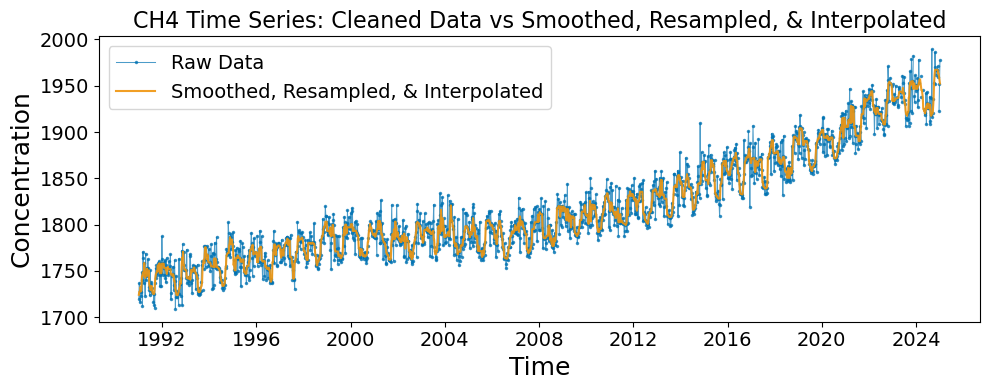

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.3677
ADF p-value 0.9154
ADF critical values: {'1%': -3.434083692100666, '5%': -2.8631892171754747, '10%': -2.5676479940036065}

KPSS statistic 6.0186
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:430: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


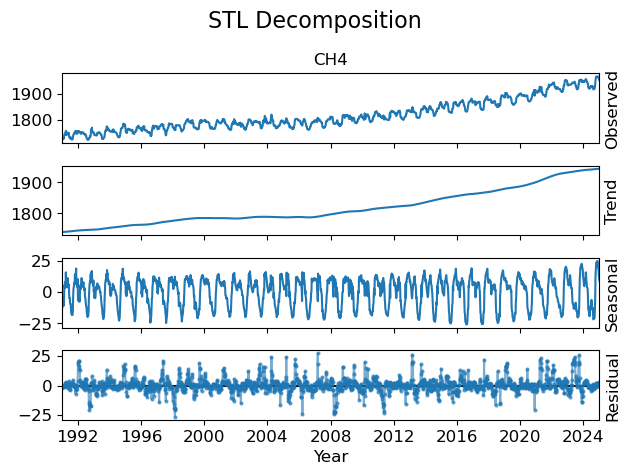

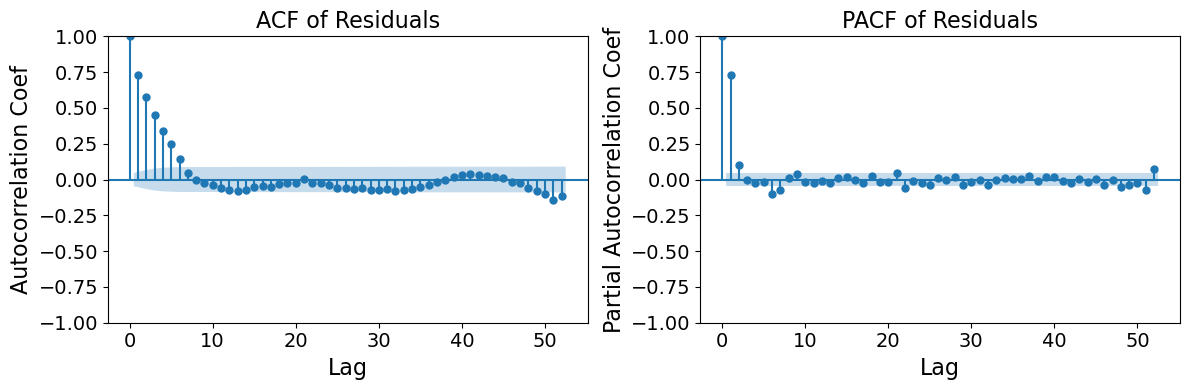


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.1036
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.1583
No heteroscedasticity detected (White test)


1991-01-06    1724.0900
1991-01-13    1727.4300
1991-01-20    1724.9975
1991-01-27    1727.4300
1991-02-03    1728.3350
Freq: W-SUN, Name: CH4, dtype: float64

In [7]:
# Run full preprocessing pipeline
ch4_preprocessed = preprocessor.fit_transform(
    df[['CH4']],
    custom_title='CH4 Time Series: Cleaned Data vs Smoothed, Resampled, & Interpolated'
)

# Show results
display(ch4_preprocessed.head())
plt.show()

The preprocessed cleaned CH4 data series is non-stationary according to the ADF and KPSS tests, which corroborates the clear, positive trend and linear regression analysis of the yearly averaged data (slope = 5.5 ppb/year, see 3_ch4_eda notebook).


STL decomposition stabilized error variance based on the Breusch-Pagan and White tests, which found no heteroscedasticity in the STL decomposition residuals.  

The ACF and PACF plots of the STL residuals show significant remaining ARIMA structure:  
- The slow decay of lags of this ACF plot suggests that the STL trend removal was insufficient and indicates the need for for non-seaonal first-order differencing (d=1).  The oscillatory pattern confirms seasonal cycles. 

- The sharp cutoff after PACF lag 1 (possibly 2) is an indicator of non-seasonal structure that remains after STL decomposition contains an autoregressive term of order 1 or 2 (p = 1 or p = 2).  

- The borderline significant spikes at Lag 52 confirm the need for seasonal differencing (D=1) and/or a seasonal AR(P) or MA(Q) term.

The next steps are to determine if the seasonal cycles are multiplicative and to examine the ACF and PACF plots of the first-differenced and seasonally-differenced data to determine the non-seasonal (p,q) and seasonal (P,Q) SARIMA orders. The differencing analysis will be done in the next notebook (4_ch4_modeling).  

# Determine if Seasonal Cycles are Addititive or Multiplicative

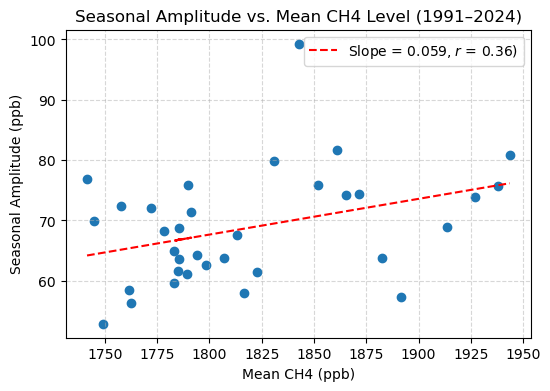

In [18]:
# plot amplitude of the seasonal cycle vs mean CH4 concentration.  
# if the seasonal cycles do not scale with the long term mean, then the cycles are additive
# if the seasonal cycles scale with the mean, then the cycles are multiplicative 

df = df.copy()
df['year'] = df.index.year

# Group by year to compute mean and amplitude
yearly = df.groupby('year')['CH4'].agg(['mean', 'max', 'min'])
yearly['amplitude'] = yearly['max'] - yearly['min']

# calculate the regression line
x = yearly['mean'].values
y = yearly['amplitude'].values
m, b = np.polyfit(x, y, 1)

# calculate the correlation coefficient (r)
corr = yearly['mean'].corr(yearly['amplitude'])

# Scatter plot: mean vs amplitude
plt.figure(figsize=(6,4))
plt.scatter(yearly['mean'], yearly['amplitude'])
plt.plot(x, m*x + b, 
         color='red', 
         linestyle='--', 
         label=f'Slope = {m:.3f}, $r$ = {corr:.2f})')
plt.xlabel('Mean CH4 (ppb)')
plt.ylabel('Seasonal Amplitude (ppb)')
plt.title('Seasonal Amplitude vs. Mean CH4 Level (1991–2024)')

# plt.plot(corr)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [19]:
df.head()

,CH4,value_unc,qcflag,year
1991-01-04,1719.845,2.71,...,1991
1991-01-11,1736.940,2.71,...,1991
1991-01-18,1728.335,2.71,...,1991
1991-01-25,1716.080,2.71,...,1991
1991-02-01,1727.430,2.71,...,1991


**Interpretation:**

- slope = 0.059 means that for every 1 unit increase in the mean CH4 level, the seasonal amplitude increases by 0.059 units. Therefore the seasonal cycles are increasing in magnitude as the CH4 concentration increases.

- correlation coefficient (r) = 0.36 suggests a weak to moderate positive linear relationship between the mean CH4 level and seasonal amplitude.  The r^2 value of 0.36^2 = ~0.13 indicates that approximately 13% of the variation in the seasonal amplitude is explained by the change in the mean CH4 level.

The positive slope and correlation coefficient (r) suggests that log transformation will be productive toward stabilizing the variance in the seasonal cycles and making the errors homoscedastic.  

## CH4 Preprocessing Results Summary

### **Preprocessing**
The preprocessing pipeline successfully handled outliers and missing (NaN) values that arose due to resampling while remaining consistent with the original time series characteristics.  

### **Stationarity Analysis**
All processing stages (raw --> smoothed --> resampled) show consistent non-stationarity:
- **ADF Test**: Fails to reject H0 (p > 0.05)  
- **KPSS Test**: Rejects H0 (p < 0.05)  
*Interpretation*: Strong trend dominance persists through preprocessing, which is expected and appropriate.  Differencing to achieve stationarity will be handled during SARIMA model specification.  

### **STL Decomposition Insights**
Analysis of the STL decomposition residuals indicates homoscedastic variance:
- **Breusch-Pagan test**: No heteroscedasticity detected (p = 0.1036)
- **White test**: No heteroscedasticity detected (p = 0.1583)
  
Constant variance in residuals is an optimal characteristic for SARIMA modeling.  

However, the seasonal amplitude vs mean CH4 concentration reveals mild multiplicative tendency (slope = 0.059, r = 0.36).  So, log transformation may still be effective for stabilizing variance for modeling wiith SARIMA.  
  
### **Autocorrelation Diagnostics**
- **ACF of Residuals**:  
  - Slow decay in ACF suggests an autoregressive (AR) component 
  - Significant lags at 1-5, potentially indicating an MA(5) process (MA = moving average)  
  - Possible significant spike at lag 52 suggests residual seasonality that may require seasonal AR or MA terms
- **PACF of Residuals**:  
  - Sharp cutoff after lag 1 suggests a strong AR(1) process 

### **Key Implications for Modeling**
1. Required transformations:  
   - **Differencing**: First order differencing will be necessary to address persistent (upward) trend
   - **Seasonal adjustment**: Seasonal terms (likely period 52) should be incorporated to capture remaining seasonal pattern
2. Initial model specification:  
   - ARIMA(1,1,5)(0-1,0-1,0-1) as starting point  
   - Seasonal periodicity: 52 weeks  
3. Variance stability:
   - The homoscedastic residuals suggest that variance-stabilizing transformations may not be necessary
   - However, the positive slope of the mean CH4 value amplitudes suggest that transformation may be necessary

# Save Preprocessed CH4 Data

## resample and interpolate value_unc and recombine into a DataFrame

**NOTE:** The following saved data ("ch4_preprocessed_df") is being saved as a record of the data for possible reference. This data will not be used for modeling and forecasting since the full, cleaned data first needs to be split into a train and test set to train and test model parameters prior to being fit/transformed to the GasPreprocessor class. 

In [12]:
value_unc_resampled = (
    df['value_unc']
    .resample('W-SUN')
    .mean()
    .interpolate(method='time')
    .ffill()
    .bfill()
)

# recombine with ch4_preprocessed data
ch4_preprocessed_df = pd.DataFrame({
    'ch4_ppb': ch4_preprocessed,
    'value_unc': value_unc_resampled.reindex(ch4_preprocessed.index)
}).reset_index(names='date')

ch4_preprocessed_df

,date,ch4_ppb,value_unc
0,1991-01-06,1724.09000,2.710
1,1991-01-13,1727.43000,2.710
2,1991-01-20,1724.99750,2.710
3,1991-01-27,1727.43000,2.710
4,1991-02-03,1728.33500,2.710
...,...,...,...
1770,2024-12-08,1963.27125,0.575
1771,2024-12-15,1963.27125,0.575
1772,2024-12-22,1959.45000,0.575
1773,2024-12-29,1955.91500,0.575


In [13]:
print(f'Number of missing values in value_unc: {ch4_preprocessed_df['value_unc'].isna().sum()}')

Number of missing values in value_unc: 0


## Save preprocessed data to ".../data/processed"

In [14]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

# save metadata
output_path = output_dir / 'ch4_preprocessed_df.csv'
(
    ch4_preprocessed_df
    .reset_index() # convert DateTimeIndex to columns
    .to_csv(output_path, index=False)
)

print(f'CH4 preprocessed data saved to:\n{output_path}')
print(f'Shape: {ch4_preprocessed_df.shape}\nLast 5 records:')
display(ch4_preprocessed_df.tail())

CH4 preprocessed data saved to:
..\data\processed\ch4_preprocessed_df.csv
Shape: (1775, 3)
Last 5 records:


,date,ch4_ppb,value_unc
1770,2024-12-08,1963.27125,0.575
1771,2024-12-15,1963.27125,0.575
1772,2024-12-22,1959.45000,0.575
1773,2024-12-29,1955.91500,0.575
1774,2025-01-05,1952.38000,0.575


In [16]:
ch4_preprocessed_df.dtypes

date         datetime64[ns]
ch4_ppb             float64
value_unc           float64
dtype: object